# Distance Lattice Housing Entrances

In this document, The distance lattice is being generated for all possible housing entrances: chosen voxels on ground level that are practically located. 

## 0. Initialization

### 0.1. Load required libraries

In [1]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
import networkx as nx
np.random.seed(0)
from scipy.interpolate import RegularGridInterpolator

### 0.2. Define the Neighborhood (Stencil)

In [2]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
stencil.set_index([0,0,0], 0)
print(stencil)

[[[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 1 0]
  [1 0 1]
  [0 1 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]]


### 0.3. Load the envelope lattice as the avialbility lattice

In [3]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/voxelized_envelope_lowres.csv')
avail_lattice = tg.lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)

# loading the lattice from csv
lattice_path = os.path.relpath('../data/voxelized_envelope_highres.csv')
avail_lattice_highres = tg.lattice_from_csv(lattice_path)

## 1. Distance Field Construction

### 1.1. Extract the connectivity graph from the lattice based on the defined stencil

In [4]:
# find the number of all voxels
vox_count = avail_lattice.size 

# initialize the adjacency matrix
adj_mtrx = np.zeros((vox_count,vox_count))

# Finding the index of the available voxels in avail_lattice
full_lattice = avail_lattice * 0 + 1
avail_index = np.array(np.where(full_lattice == 1)).T


# fill the adjacency matrix using the list of all neighbours
for vox_loc in avail_index:
    # find the 1D id
    vox_id = np.ravel_multi_index(vox_loc, avail_lattice.shape)
    # retrieve the list of neighbours of the voxel based on the stencil
    vox_neighs = avail_lattice.find_neighbours_masked(stencil, loc = vox_loc)
    # iterating over the neighbours
    for neigh in vox_neighs:
        # setting the entry to one
        adj_mtrx[vox_id, neigh] = 1.0

# construct the graph 
g = nx.from_numpy_array(adj_mtrx)

### 1.2. Compute distances on the graph

In [5]:
# compute the distance of all voxels to all voxels using floyd warshal algorithm
dist_mtrx = nx.floyd_warshall_numpy(g)

### 1.3. Construct distances to each housing entrance

In [6]:
# select the corresponding row in the matrix
ent_1_dist = dist_mtrx[136]

# find the maximum valid value
max_valid = np.ma.masked_invalid(ent_1_dist).max()

# set the infinities to one more than the maximum valid values
ent_1_dist[ent_1_dist == np.inf] = max_valid + 1

In [7]:
# select the corresponding row in the matrix
ent_2_dist = dist_mtrx[213]

# find the maximum valid value
max_valid = np.ma.masked_invalid(ent_2_dist).max()

# set the infinities to one more than the maximum valid values
ent_2_dist[ent_2_dist == np.inf] = max_valid + 1

In [8]:
# select the corresponding row in the matrix
ent_3_dist = dist_mtrx[223]

# find the maximum valid value
max_valid = np.ma.masked_invalid(ent_3_dist).max()

# set the infinities to one more than the maximum valid values
ent_3_dist[ent_3_dist == np.inf] = max_valid + 1

### 1.4. Combining different distance fields

In [9]:
# finding the shortest distance to one of the entrances for each voxel
ent_dist_pt1 = np.minimum(ent_1_dist, ent_2_dist)
dist_housing_ent = np.minimum(ent_dist_pt1, ent_3_dist)

# mapping the values from (0, max) to (1, 0)
ent_flat = 1 - dist_housing_ent / np.max(dist_housing_ent)

# constructing the lattice
ent_acc_lattice = tg.to_lattice(ent_flat.reshape(avail_lattice.shape), avail_lattice)

### 1.5. Interpolation

In [10]:
def interpolate(info_lowres, base_highres):
    # line spaces
    x_space = np.linspace(info_lowres.minbound[0], info_lowres.maxbound[0],info_lowres.shape[0])
    y_space = np.linspace(info_lowres.minbound[1], info_lowres.maxbound[1],info_lowres.shape[1])
    z_space = np.linspace(info_lowres.minbound[2], info_lowres.maxbound[2],info_lowres.shape[2])

    # interpolation function
    interpolating_function = RegularGridInterpolator((x_space - 1, y_space - 1 , z_space - 1), info_lowres, bounds_error=False, fill_value=None)

    # high_res lattice
    full_lattice = base_highres + 1

    # sample points
    sample_points = full_lattice.centroids

    # interpolation
    interpolated_values = interpolating_function(sample_points)

    # lattice construction
    info_highres = tg.to_lattice(interpolated_values.reshape(base_highres.shape), base_highres)

    # nulling the unavailable cells
    info_highres *= base_highres

    return info_highres

In [11]:
ent_acc_highres = interpolate(ent_acc_lattice, avail_lattice_highres)
# ent_acc_highres = ent_acc_lattice

### 1.6. Visualize the distance lattice

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

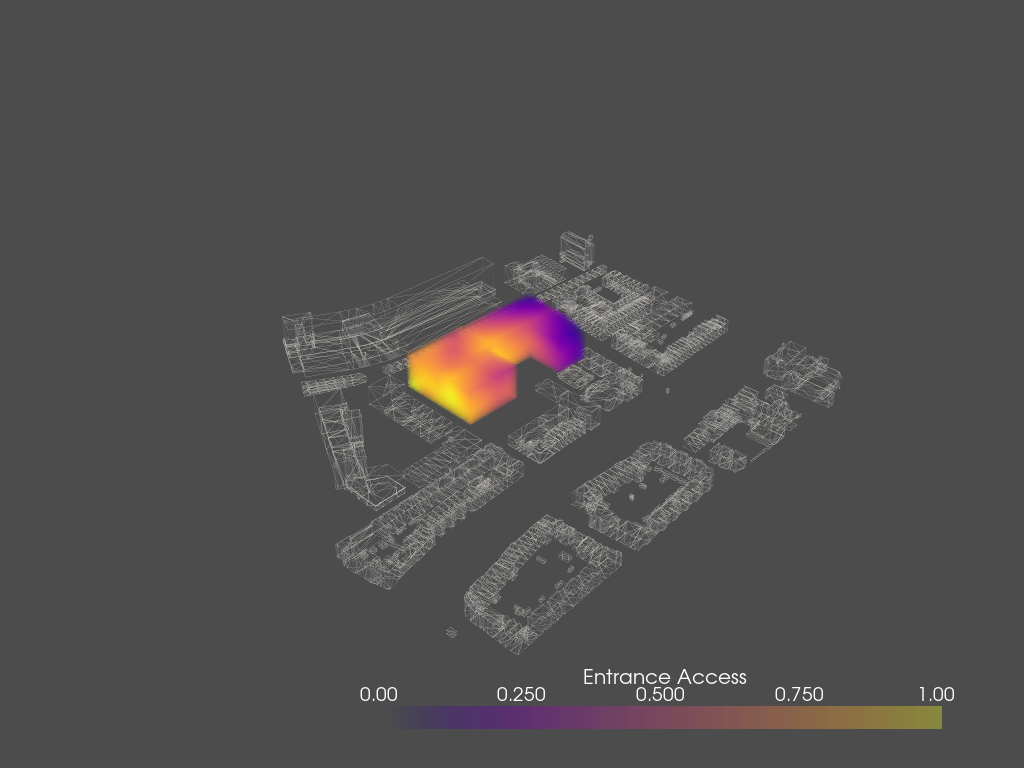

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [12]:
# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

# load the mesh from file
context_path = os.path.relpath('../data/immediate_context.obj')
context_mesh = tm.load(context_path)

# initiating the plotter
p = pv.Plotter(notebook=True)

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = ent_acc_highres.shape
# The bottom left corner of the data set
grid.origin = ent_acc_highres.minbound
# These are the cell sizes along each axis
grid.spacing = ent_acc_highres.unit

# Add the data values to the cell data
grid.point_arrays["Entrance Access"] = ent_acc_highres.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# adding the volume
opacity = np.array([0.0,0.6,0.6,0.6,0.6,0.6,0.6]) * 0.6
p.add_volume(grid, cmap="plasma", clim=[0.0, 1] ,opacity=opacity)

# plotting
p.show(use_ipyvtk=True)

#saving and plotting
png_path = os.path.relpath('../screenshots/3.6_lattice_housing.png')
p.show(screenshot= png_path)

### 1.7. Save Entrance Access Lattice to CSV

In [16]:
# save the entrance access lattice to csv
csv_path = os.path.relpath('../data/ent_access_highres_housing.csv')
ent_acc_highres.to_csv(csv_path)

### Credits

In [17]:
__author__ = "Shervin Azadi and Pirouz Nourian"
__editor__ = "Maartje Damen"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on MCDA and Path Finding for Generative Spatial Relations"